In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

In [2]:
# os.makedirs('DataLagsPkl')
# df = pd.DataFrame()
# for filename in tqdm(os.listdir('DataLags/')):
#     if '.csv' in filename:
#         data = pd.read_csv(f'DataLags/{filename}')
#         data.to_pickle(f'DataLagsPkl/{filename.replace("csv", "pkl")}')
# #         df = pd.concat([df, data])

## Read data

In [3]:
N_READ_FILES = 5

df = pd.DataFrame()
for filename in tqdm(os.listdir('DataLagsPkl//')[:N_READ_FILES]):
    if '.pkl' in filename:
        data = pd.read_pickle(f'DataLagsPkl//{filename}')
        df = pd.concat([df, data])
        
df = df.reset_index(drop=True)

  0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
print(df.shape)

(1615127, 140)


In [5]:
df_sample = df.copy()

## Merge locations

In [6]:
location_dict = pd.read_csv('LOCATION.csv', sep=';').rename(
    columns={
        'STORE_LOCATION_RK': 'store_location_rk',
        'STORE_LOCATION_LVL_RK3': 'city',
        'STORE_LOCATION_LVL_RK2': 'region'
    }
)

In [7]:
df_merged = df_sample.merge(location_dict[['store_location_rk', 'city', 'region']], how='left', on='store_location_rk')

In [8]:
assert df_merged['city'].isna().sum() == 0
assert df_merged['region'].isna().sum() == 0

## Clustering 

In [9]:
df_merged['period_start_dt'].max()

'2019-12-30'

In [10]:
train_split_date = '2019-10-01'

df_merged_train = df_merged[df_merged['period_start_dt'] <= train_split_date]
df_merged_test = df_merged[df_merged['period_start_dt'] > train_split_date]


print(f'Train contains {round(df_merged_train.shape[0] / df_merged.shape[0], 2) * 100}% of data')
print(f'Test contains {round(df_merged_test.shape[0] / df_merged.shape[0], 2) * 100}% of data')

Train contains 90.0% of data
Test contains 10.0% of data


In [11]:
## take top10 products by demand sum

# top_sum = df_merged.groupby('city')['demand'].mean()
# idx = top_sum.sort_values(ascending=False).head(10).index
# df_top = df[df['product_rk'].isin(idx)]
# top_sum

## ByCity

In [12]:
# df_merged = df_merged[df_merged['city'] != 39]

In [13]:
## calculate mean demand for every pair product-city

demand_top_sku_pivot = pd.pivot_table(df_merged_train.groupby(['product_rk', 'city'])['demand'].mean().reset_index(), 
                                      index='product_rk', values='demand', columns='city', fill_value=0).rename_axis(None, axis=1)
demand_top_sku_pivot.columns = demand_top_sku_pivot.columns.astype(str)
demand_top_sku_pivot.head()



,39,54,203,219
product_rk,,,,
11389,0.0,0.000000,1.095238,0.0
11390,0.0,0.000000,0.248875,0.0
11391,0.0,0.000000,0.267311,0.0
11403,0.0,0.000000,0.311703,0.0
11404,0.0,0.443989,0.904972,0.0


In [14]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [15]:
agcl =  AgglomerativeClustering(distance_threshold=0, n_clusters=None)
agcl = agcl.fit(demand_top_sku_pivot)
# plot the top three levels of the dendrogram
# plot_dendrogram(agcl, truncate_mode="level", p=3)

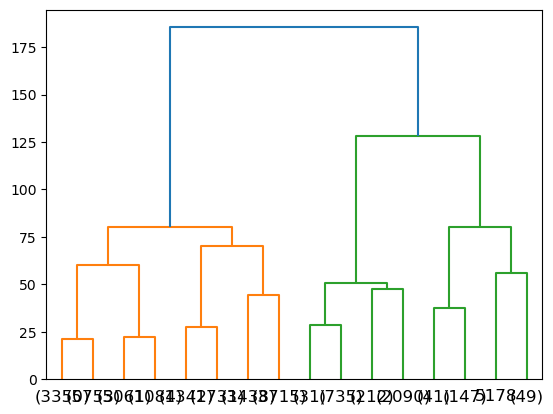

In [16]:
plot_dendrogram(agcl, truncate_mode="level", p=3)

In [17]:
## how to define number of clusters?

N_CLUSTERS = 4
agcl =  AgglomerativeClustering(n_clusters=N_CLUSTERS)
cluster_labels = agcl.fit_predict(demand_top_sku_pivot)

## add labels to dataset
demand_top_sku_pivot['label'] = cluster_labels
df_merged = df_merged.merge(demand_top_sku_pivot.reset_index()[['product_rk', 'label']], on='product_rk')
df_merged = df_merged.sort_values('period_start_dt')
df_merged.head()

,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,...,demand_lag52_w112D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,demand_lag52_w224D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag52_w224D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,demand_lag52_w728D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag52_w728D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,demand_lag52_w1456D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag52_w1456D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,city,region,label
0,44467,1143,2016-12-26,1.344828,1.0,0.0,312.0,271.285714,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39,10,2
395998,75139,1034,2016-12-26,1.062500,1.0,0.0,2047.0,1023.500000,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203,10,1
11476,50371,862,2016-12-26,2.200000,1.0,0.0,159.0,159.000000,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54,10,2
53571,27268,1143,2016-12-26,0.538462,1.0,0.0,5564.0,2782.000000,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39,10,1
396036,75139,1281,2016-12-26,2.000000,1.0,0.0,2047.0,1023.500000,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203,10,1


## Predictions

### Splitting data

In [18]:
## now with labels

train_split_date = '2019-10-01'

df_merged_train = df_merged[df_merged['period_start_dt'] <= train_split_date]
df_merged_test = df_merged[df_merged['period_start_dt'] > train_split_date]


print(f'Train contains {round(df_merged_train.shape[0] / df_merged.shape[0], 2) * 100}% of data')
print(f'Test contains {round(df_merged_test.shape[0] / df_merged.shape[0], 2) * 100}% of data')

Train contains 91.0% of data
Test contains 9.0% of data


In [19]:
# df[df['period_start_dt'] > '2018-09-17'].groupby('period_start_dt')['label'].count().plot.bar(figsize=(20, 8))

In [20]:
# train_split_date = '2018-12-03'
# val_split_date = '2019-05-20'

# train = df_merged[df_merged['period_start_dt'] <= train_split_date]
# val = df_merged[(df_merged['period_start_dt'] > train_split_date) & (df_merged['period_start_dt'] <= val_split_date)]
# test = df_merged[df_merged['period_start_dt'] > val_split_date]


# print(f'Train contains {round(train.shape[0] / df_merged.shape[0], 2) * 100}% of data')
# print(f'Val contains {round(val.shape[0] / df_merged.shape[0], 2) * 100}% of data')
# print(f'Test contains {round(test.shape[0] / df_merged.shape[0], 2) * 100}% of data')

In [21]:
# main_cols = ['product_rk', 'city']
# lag_cols = train.columns[train.columns.str.contains('demand_')]

# train_cols = main_cols + list(lag_cols)

# X_train, y_train = train[train_cols].values, train['demand']
# X_val, y_val = val[train_cols].values, train['demand']
# X_test, y_test = test[train_cols].values, test['demand']

In [23]:
main_cols = ['product_rk', 'city']
lag_cols = df_merged_train.columns[df_merged_train.columns.str.contains('demand_')]

train_cols = main_cols + list(lag_cols)

X_train, y_train = df_merged_train[train_cols].values, df_merged_train['demand']
X_test, y_test = df_merged_test[train_cols].values, df_merged_test['demand']

### No clustering

In [24]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

cat = CatBoostRegressor(iterations=100)
cat.fit(X_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.5
0:	learn: 2.7881405	total: 253ms	remaining: 25.1s
1:	learn: 2.7129834	total: 435ms	remaining: 21.3s
2:	learn: 2.6771735	total: 637ms	remaining: 20.6s
3:	learn: 2.6588302	total: 865ms	remaining: 20.7s
4:	learn: 2.6482847	total: 1.07s	remaining: 20.3s
5:	learn: 2.6362025	total: 1.24s	remaining: 19.5s
6:	learn: 2.6322252	total: 1.47s	remaining: 19.5s
7:	learn: 2.6225516	total: 1.7s	remaining: 19.5s
8:	learn: 2.6173583	total: 1.84s	remaining: 18.6s
9:	learn: 2.6138056	total: 2.07s	remaining: 18.6s
10:	learn: 2.6039741	total: 2.22s	remaining: 18s
11:	learn: 2.6009854	total: 2.45s	remaining: 18s
12:	learn: 2.5974469	total: 2.6s	remaining: 17.4s
13:	learn: 2.5911150	total: 2.81s	remaining: 17.3s
14:	learn: 2.5857616	total: 2.97s	remaining: 16.9s
15:	learn: 2.5837823	total: 3.2s	remaining: 16.8s
16:	learn: 2.5759926	total: 3.38s	remaining: 16.5s
17:	learn: 2.5741698	total: 3.66s	remaining: 16.7s
18:	learn: 2.5642519	total: 3.79s	remaining: 16.2s
19:	learn: 2.5586654	to

In [25]:
preds = cat.predict(X_test)

In [26]:
mse = mean_squared_error(preds, y_test)
print('Error without clustering:', mse)

Error without clustering: 4.436971401822805


### With clustering

In [28]:
mse_sum = 0
for label in df_merged_train['label'].unique():
    
    X_train, y_train = df_merged_train[df_merged_train['label'] == label][['product_rk', 'city']].values, df_merged_train[df_merged_train['label'] == label]['demand']
    X_test, y_test = df_merged_test[df_merged_test['label'] == label][['product_rk', 'city']].values, df_merged_test[df_merged_test['label'] == label]['demand']
    
    cat = CatBoostRegressor(iterations=100)
    cat.fit(X_train, y_train)
    
    preds = cat.predict(X_test)
    
    mse_sum += mean_squared_error(preds, y_test) * X_train.shape[0]

Learning rate set to 0.5
0:	learn: 1.8679144	total: 20.6ms	remaining: 2.04s
1:	learn: 1.8632363	total: 39.3ms	remaining: 1.92s
2:	learn: 1.8594138	total: 58.6ms	remaining: 1.89s
3:	learn: 1.8573105	total: 78.7ms	remaining: 1.89s
4:	learn: 1.8555872	total: 99.5ms	remaining: 1.89s
5:	learn: 1.8550995	total: 119ms	remaining: 1.86s
6:	learn: 1.8540859	total: 140ms	remaining: 1.86s
7:	learn: 1.8525716	total: 160ms	remaining: 1.84s
8:	learn: 1.8498961	total: 183ms	remaining: 1.85s
9:	learn: 1.8490830	total: 207ms	remaining: 1.86s
10:	learn: 1.8480646	total: 229ms	remaining: 1.85s
11:	learn: 1.8476427	total: 248ms	remaining: 1.82s
12:	learn: 1.8465972	total: 273ms	remaining: 1.82s
13:	learn: 1.8456636	total: 299ms	remaining: 1.84s
14:	learn: 1.8453508	total: 326ms	remaining: 1.84s
15:	learn: 1.8450958	total: 347ms	remaining: 1.82s
16:	learn: 1.8446550	total: 369ms	remaining: 1.8s
17:	learn: 1.8431616	total: 397ms	remaining: 1.81s
18:	learn: 1.8425871	total: 427ms	remaining: 1.82s
19:	learn: 1

65:	learn: 0.8168384	total: 1.89s	remaining: 973ms
66:	learn: 0.8167975	total: 1.93s	remaining: 948ms
67:	learn: 0.8167644	total: 1.96s	remaining: 920ms
68:	learn: 0.8167178	total: 1.99s	remaining: 892ms
69:	learn: 0.8166867	total: 2.02s	remaining: 864ms
70:	learn: 0.8166359	total: 2.04s	remaining: 835ms
71:	learn: 0.8166090	total: 2.08s	remaining: 807ms
72:	learn: 0.8165430	total: 2.1s	remaining: 779ms
73:	learn: 0.8165074	total: 2.13s	remaining: 750ms
74:	learn: 0.8164694	total: 2.17s	remaining: 722ms
75:	learn: 0.8164261	total: 2.19s	remaining: 693ms
76:	learn: 0.8163965	total: 2.23s	remaining: 665ms
77:	learn: 0.8163198	total: 2.26s	remaining: 637ms
78:	learn: 0.8162480	total: 2.29s	remaining: 609ms
79:	learn: 0.8161932	total: 2.32s	remaining: 581ms
80:	learn: 0.8161808	total: 2.35s	remaining: 552ms
81:	learn: 0.8161360	total: 2.39s	remaining: 524ms
82:	learn: 0.8161244	total: 2.42s	remaining: 495ms
83:	learn: 0.8161140	total: 2.44s	remaining: 465ms
84:	learn: 0.8160943	total: 2.48

53:	learn: 12.3341352	total: 188ms	remaining: 160ms
54:	learn: 12.3334339	total: 193ms	remaining: 158ms
55:	learn: 12.3330214	total: 196ms	remaining: 154ms
56:	learn: 12.3323915	total: 200ms	remaining: 151ms
57:	learn: 12.3310892	total: 203ms	remaining: 147ms
58:	learn: 12.3306477	total: 211ms	remaining: 146ms
59:	learn: 12.3303931	total: 214ms	remaining: 143ms
60:	learn: 12.3298816	total: 218ms	remaining: 140ms
61:	learn: 12.3290631	total: 224ms	remaining: 137ms
62:	learn: 12.3279755	total: 228ms	remaining: 134ms
63:	learn: 12.3276776	total: 231ms	remaining: 130ms
64:	learn: 12.3272578	total: 235ms	remaining: 126ms
65:	learn: 12.3265621	total: 239ms	remaining: 123ms
66:	learn: 12.3263453	total: 243ms	remaining: 120ms
67:	learn: 12.3259944	total: 247ms	remaining: 116ms
68:	learn: 12.3252701	total: 251ms	remaining: 113ms
69:	learn: 12.3249962	total: 255ms	remaining: 109ms
70:	learn: 12.3247554	total: 258ms	remaining: 106ms
71:	learn: 12.3240885	total: 262ms	remaining: 102ms
72:	learn: 1

In [29]:
mse = mse_sum / df_merged.shape[0]
print('Error with clustering:', mse)

Error with clustering: 3.9028595285496404


In [233]:
# store = 926
# product = 45312


# df[(df['product_rk'] == product) & (df['store_location_rk'] == store)].sort_values('period_start_dt').\
# set_index('period_start_dt')[['demand']].plot(figsize=(10, 8), color='blue', label=f'Demand_Store{store}_product{product}')
# plt.xlabel('Date', weight='bold', size=12)
# plt.ylabel('Demand', weight='bold', size=12)
# plt.legend()
